# Постановка задачи
Для уравнения теплопроводности
$$\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2} + \sin(x) + \frac{2t}{t^2+1}, x \in [0,\pi], t \in [0,10]$$
с начальными условиями
$$u(x,0) = \sin(x), x \in [0,\pi],$$
и граничными условиями
$$u(0,t) = \ln(t^2+1), u(\pi,t) = \ln(t^2+1), t \in [0,10]$$
запрограммировать схемы: явную, неявную, Кранка–Никольсон.
За базовый вариант взять сетку с шагами $h = \pi/5$ и $\tau = 0.25$.
Уменьшить шаги по времени и по пространству. Как влияет соотношение шагов на точность решения?  
Указание. Начально краевая задача имеет точное решение
$$u(x,t) = \sin(x) + \ln(t^2+1)$$

# Введение обозначений
В общем случае начально-краевая задача для уравнения теплопроводности имеет следующий вид:
$$\frac{\partial u}{\partial t} = a^2\frac{\partial^2 u}{\partial x^2} + g(x,t), x \in [0,l], t \in [0,T]$$
$$u(x,0) = u_0(x), x \in [0,l],$$
$$u(0,t) = \mu_0(t), t \in [0,T]$$
$$u(l,t) = \mu_1(t), t \in [0,T]$$
В нашем случае параметры следующие:  
$$g(x,t)=\sin(x) + \frac{2t}{t^2+1}, x \in [0,l], t \in [0,T]$$
$$u_0(x)=\sin(x), x \in [0,l]$$
$$\mu_0(t)=\ln(t^2+1), t \in [0,T]$$
$$\mu_1(t)=\ln(t^2+1), t \in [0,T]$$
$$a=1, l=\pi, T=10$$
Далее за $u_i^j$ будем обозначать приближённое значение $u(x_i,t_j)$

In [1]:
import math
import numpy as np

a_squared = 1
l = math.pi
T = 10

def g(x,t):
    return math.sin(x) + 2*t/(t*t+1)
g = np.vectorize(g)

def u0(x):
    return math.sin(x)

def mu0(t):
    return math.log(t*t+1)
mu1 = mu0

def u_exact(x,t):
    return math.sin(x) + math.log(t*t+1)
u_exact = np.vectorize(u_exact)

def get_x(i,h):
    return i*h
get_x = np.vectorize(get_x)
    
def get_t(j,tau):
    return j*tau
get_t = np.vectorize(get_t)

# Явная схема
имеет вид:
$$\frac{u_i^{j+1}-u_i^j}{\tau} = a^2\frac{u_{i+1}^j-2u_i^j+u_{i-1}^j}{h^2} + g_i^j$$
Выразим отсюда $u_i^{j+1}:$  
$$u_i^{j+1} = \tau a^2\frac{u_{i+1}^j-2u_i^j+u_{i-1}^j}{h^2} + \tau g_i^j + u_i^j$$
и подставим наши параметры:
$$u_i^{j+1} = \tau\frac{u_{i+1}^j-2u_i^j+u_{i-1}^j}{h^2} + \tau\sin(x_i) + \tau\frac{2t_j}{t_j^2+1} + u_i^j$$

In [2]:
class FiniteDifferenceMethod:
    def __init__(self,h,tau):
        self.h = h
        self.tau = tau
        xn = int(round(l/h))+1
        tn = int(round(T/tau))+1
        self.grid = np.zeros((xn,tn))
        self.x = np.vectorize(self.x)
        self.t = np.vectorize(self.t)
        xn = int(round(l/h))+1
        tn = int(round(T/tau))+1
        self.grid = np.zeros((xn,tn))
    
    def nearest_node(self,x,t):
        i = int(round(x / self.h))
        j = int(round(t / self.tau))
        return i, j
    
    def x(self,i):
        return get_x(i,self.h)
    
    def t(self,j):
        return get_x(j,self.tau)
    
    def calc(self,x,t):
        i,j = self.nearest_node(x,t)
        return self.grid[i,j]

In [3]:
class ExplicitMethod(FiniteDifferenceMethod):
    def fit(self):
        h = self.h
        tau = self.tau
        u = self.grid
        N,M = u.shape
        N -= 1
        M -= 1
        # Начальные условия:
        for i in range(1,N):
            x = self.x(i)
            u[i,0] = u0(x)
        # Граничные условия:
        for j in range(0,M+1):
            t = self.t(j)
            u[0,j] = mu0(t)
            u[N,j] = mu1(t)
        # Явная схема:
        for j in range(0,M):
            t = self.t(j)
            for i in range(1,N):
                x = self.x(i)
                u[i,j+1] = tau*a_squared / (h**2) * (u[i+1,j]-2*u[i,j]+u[i-1,j]) + tau*g(x,t) + u[i,j]
        return self

In [4]:
expl = ExplicitMethod(math.pi/5,0.25).fit()

In [5]:
expl.calc(math.pi/5,0.25)

0.59255642137944287

In [6]:
u_exact(math.pi/5,0.25)

array(0.6484098741089079)

# Неявная схема
имеет вид:
$$\frac{u_i^{j+1}-u_i^j}{\tau} = a^2\frac{u_{i+1}^{j+1}-2u_i^{j+1}+u_{i-1}^{j+1}}{h^2} + g_i^j$$


Добавим начальное и граничные условия, подставим наши параметры и получим систему

$$\begin{cases}
  u_0^{j+1} = \ln(t_{j+1}^2+1) \\
  \frac{\tau}{h^2}u_{i-1}^{j+1}-\big(1+\frac{2\tau}{h^2}\big)u_i^{j+1}+\frac{\tau}{h^2}u_{i+1}^{j+1} = -\big(u_i^j+\tau\sin(x_i) + \tau\frac{2t_j}{t_j^2+1}\big), \; i = 1,\dots,N-1 \\
  u_N^{j+1} = \ln(t_{j+1}^2+1) \\
\end{cases}$$
с трёхдиагональной матрицей
$$\left(
\begin{array}{cccccccc|c}
    1 & 0 & 0 & 0 & \dots & 0 & 0 & 0 & \ln(t_{j+1}^2+1) \\
    \frac{\tau}{h^2} & -(1+\frac{2\tau}{h^2}) & \frac{\tau}{h^2} & 0 & \dots & 0 & 0 & 0 & -\big(u_1^j+\tau\sin(x_1) + \tau\frac{2t_j}{t_j^2+1}\big) \\
    0 & \frac{\tau}{h^2} & -(1+\frac{2\tau}{h^2}) & \frac{\tau}{h^2} & \dots & 0 & 0 & 0 & -\big(u_2^j+\tau\sin(x_2) + \tau\frac{2t_j}{t_j^2+1}\big) \\
    \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \vdots \\
    0 & 0 & 0 & 0 & \dots & \frac{\tau}{h^2} & 0 & 0 & -\big(u_{N-3}^j+\tau\sin(x_{N-3}) + \tau\frac{2t_j}{t_j^2+1}\big) \\\\
    0 & 0 & 0 & 0 & \dots & -(1+\frac{2\tau}{h^2}) & \frac{\tau}{h^2} & 0 & -\big(u_{N-2}^j+\tau\sin(x_{N-2}) + \tau\frac{2t_j}{t_j^2+1}\big) \\
    0 & 0 & 0 & 0 & \dots & \frac{\tau}{h^2} & -(1+\frac{2\tau}{h^2}) & \frac{\tau}{h^2} & -\big(u_{N-1}^j+\tau\sin(x_{N-1}) + \tau\frac{2t_j}{t_j^2+1}\big) \\
    0 & 0 & 0 & 0 & \dots & 0 & 0 & 1 & \ln(t_{j+1}^2+1)
    \end{array}
\right)$$
для каждого $j = 0,\dots, M-1$  
с начальным условием
$$u_i^0 = \sin(x_i), \; i = 1,\dots,N-1$$
Для каждого $j$ система решается методом прогонки

In [7]:
from scipy.linalg import solve_banded

def tdma(ud, d, ld, r):
    ab = np.matrix([ud, d, ld])
    return solve_banded((1, 1), ab, r)

class ImplicitMethod(FiniteDifferenceMethod):
    def fit(self):
        h = self.h
        tau = self.tau
        u = self.grid
        N,M = u.shape
        N -= 1
        M -= 1
        # Начальные условия:
        for i in range(1,N):
            x = self.x(i)
            u[i,0] = u0(x)
        # Граничные условия:
        for j in range(0,M+1):
            t = self.t(j)
            u[0,j] = mu0(t)
            u[N,j] = mu1(t)
        # Неявная схема:
        ud = np.insert(np.repeat(tau/(h**2), N-1), [0,0], 0)
        d = np.insert(np.repeat(-(1+2*tau/(h**2)), N-1), [0,N-1], 1)
        ld = np.insert(np.repeat(tau/(h**2), N-1), [N-1,N-1], 0)
        xs = self.x(np.arange(1,N))
        for j in range(0,M):
            t = self.t(j)
            t1 = self.t(j+1)
            r = -(u[1:N,j] + tau*g(xs,t1))
            r = np.insert(r, 0, mu0(t1))
            r = np.insert(r, N, mu1(t1))
            u[:,j+1] = tdma(ud, d, ld, r)
        return self

In [8]:
impl = ImplicitMethod(math.pi/5,0.25).fit()

In [9]:
impl.calc(math.pi/5,0.25)

0.69140672045884288

In [10]:
u_exact(math.pi/5,0.25)

array(0.6484098741089079)

# Схема Кранка–Никольсон
имеет вид:
$$\frac{u_i^{j+1}-u_i^j}{\tau} = \frac{a^2}{2}\big(\frac{u_{i+1}^j-2u_i^j+u_{i-1}^j}{h^2} + \frac{u_{i+1}^{j+1}-2u_i^{j+1}+u_{i-1}^{j+1}}{h^2}\big) + g_i^j$$


Добавим начальное и граничные условия, подставим наши параметры и получим систему

$$\begin{cases}
  u_0^{j+1} = \ln(t_{j+1}^2+1) \\
  \frac{\tau}{2h^2}u_{i-1}^{j+1}-\big(1+\frac{\tau}{h^2}\big)u_i^{j+1}+\frac{\tau}{2h^2}u_{i+1}^{j+1} = -\big(\frac{\tau}{2h^2}u_{i-1}^j+\big(1-\frac{\tau}{h^2}\big)u_i^j+\frac{\tau}{2h^2}u_{i+1}^j + \tau\sin(x_i) + \tau\frac{2t_j}{t_j^2+1}\big), \; i = 1,\dots,N-1 \\
  u_N^{j+1} = \ln(t_{j+1}^2+1) \\
\end{cases}$$
с трёхдиагональной матрицей
$$\left(
\begin{array}{cccccccc|c}
    1 & 0 & 0 & 0 & \dots & 0 & 0 & 0 & \ln(t_{j+1}^2+1) \\
    \frac{\tau}{2h^2} & -(1+\frac{\tau}{h^2}) & \frac{\tau}{2h^2} & 0 & \dots & 0 & 0 & 0 & -\big(\frac{\tau}{2h^2}u_0^j+\big(1-\frac{\tau}{h^2}\big)u_1^j+\frac{\tau}{2h^2}u_2^j + \tau\sin(x_1) + \tau\frac{2t_j}{t_j^2+1}\big) \\
    0 & \frac{\tau}{2h^2} & -(1+\frac{\tau}{h^2}) & \frac{\tau}{2h^2} & \dots & 0 & 0 & 0 & -\big(\frac{\tau}{2h^2}u_1^j+\big(1-\frac{\tau}{h^2}\big)u_2^j+\frac{\tau}{2h^2}u_3^j + \tau\sin(x_2) + \tau\frac{2t_j}{t_j^2+1}\big) \\
    \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \vdots \\
    0 & 0 & 0 & 0 & \dots & \frac{\tau}{2h^2} & 0 & 0 & -\big(\frac{\tau}{2h^2}u_{N-4}^j+\big(1-\frac{\tau}{h^2}\big)u_{N-3}^j+\frac{\tau}{2h^2}u_{N-2}^j + \tau\sin(x_{N-3}) + \tau\frac{2t_j}{t_j^2+1}\big) \\
    0 & 0 & 0 & 0 & \dots & -(1+\frac{\tau}{h^2}) & \frac{\tau}{2h^2} & 0 & -\big(\frac{\tau}{2h^2}u_{N-3}^j+\big(1-\frac{\tau}{h^2}\big)u_{N-2}^j+\frac{\tau}{2h^2}u_{N-1}^j + \tau\sin(x_{N-2}) + \tau\frac{2t_j}{t_j^2+1}\big) \\
    0 & 0 & 0 & 0 & \dots & \frac{\tau}{2h^2} & -(1+\frac{\tau}{h^2}) & \frac{\tau}{2h^2} & -\big(\frac{\tau}{2h^2}u_{N-2}^j+\big(1-\frac{\tau}{h^2}\big)u_{N-1}^j+\frac{\tau}{2h^2}u_N^j + \tau\sin(x_{N-1}) + \tau\frac{2t_j}{t_j^2+1}\big) \\
    0 & 0 & 0 & 0 & \dots & 0 & 0 & 1 & \ln(t_{j+1}^2+1)
    \end{array}
\right)$$
для каждого $j = 0,\dots, M-1$  
с начальным условием
$$u_i^0 = \sin(x_i), \; i = 1,\dots,N-1$$
Для каждого $j$ система решается методом прогонки

In [11]:
class CrankNicolsonMethod(FiniteDifferenceMethod):
    def fit(self):
        h = self.h
        tau = self.tau
        u = self.grid
        N,M = u.shape
        N -= 1
        M -= 1
        # Начальные условия:
        for i in range(1,N):
            x = self.x(i)
            u[i,0] = u0(x)
        # Граничные условия:
        for j in range(0,M+1):
            t = self.t(j)
            u[0,j] = mu0(t)
            u[N,j] = mu1(t)
        # Неявная схема:
        ud = np.insert(np.repeat(tau/(2*h**2), N-1), [0,0], 0)
        d = np.insert(np.repeat(-(1+tau/(h**2)), N-1), [0,N-1], 1)
        ld = np.insert(np.repeat(tau/(2*h**2), N-1), [N-1,N-1], 0)
        
        xs = self.x(np.arange(1,N))
        for j in range(0,M):
            t = self.t(j)
            t1 = self.t(j+1)
            r = -(tau/(2*h**2)*u[0:N-1,j] + (1-tau/(h**2))*u[1:N,j] + tau/(2*h**2)*u[2:N+1,j] + tau*g(xs,t1))
            r = np.insert(r, 0, mu0(t1))
            r = np.insert(r, N, mu1(t1))
            u[:,j+1] = tdma(ud, d, ld, r)
        return self

In [12]:
cn = CrankNicolsonMethod(math.pi/5,0.25).fit()

In [13]:
cn.calc(math.pi/5,0.25)

0.69809356885134166

In [14]:
u_exact(math.pi/5,0.25)

array(0.6484098741089079)

# Оценка погрешности
Оценим максимум модуля погрешности для различных значений $h, \tau$

In [15]:
def norm(grid_function):
    return np.max(np.abs(grid_function))

def proj(func, h, tau):
    xn = int(round(l/h))+1
    tn = int(round(T/tau))+1
    xs = np.tile(get_x(np.arange(0,xn),h), (tn, 1)).T
    ts = np.tile(get_t(np.arange(0,tn),tau), (xn, 1))
    f_proj = func(xs,ts)
    return f_proj

def eps(f_approx, f_exact, h, tau):
    return f_approx - proj(f_exact, h, tau)

def approx_error(method, h, tau, f_exact=u_exact):
    f_approx = method(h, tau).fit().grid
    return norm(eps(f_approx, f_exact, h, tau))

In [29]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

def evaluate_quality(method, f_exact=u_exact):
    hn = 5
    taun = 6
    results = pd.DataFrame(columns=['h', 'tau', 'error'])
    for h in (math.pi/5) / np.arange(1,hn+1):
        for tau in 0.5 / 2 ** np.arange(1,taun+1):
            error = approx_error(method, h, tau, f_exact)
            results = results.append({'h': h, 'tau': tau, 'error': error}, ignore_index=True)
    return results

In [30]:
def plot_errors(results):
    sns.heatmap(results.pivot("h", "tau", "error"), annot=True)
    sns.plt.suptitle('Зависимость максимума модуля погрешности от шагов по времени и пространству')
    plt.show()

### Схема Кранка–Никольсон

In [31]:
cn_results = evaluate_quality(CrankNicolsonMethod)

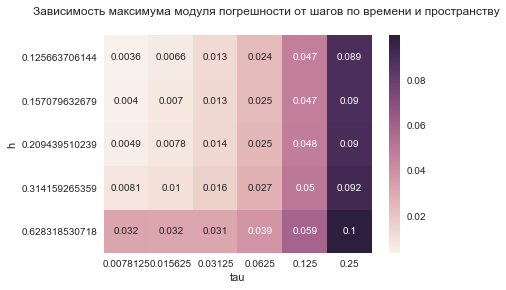

In [32]:
plot_errors(cn_results)

### Неявный метод

In [33]:
impl_results = evaluate_quality(ImplicitMethod)

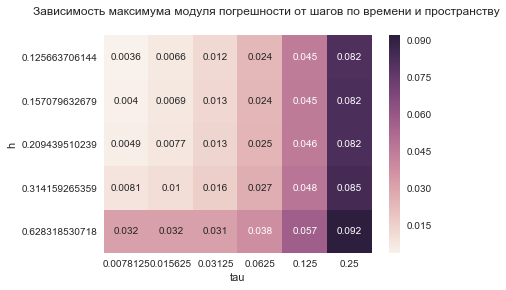

In [34]:
plot_errors(impl_results)

### Явный метод

In [35]:
expl_results = evaluate_quality(ExplicitMethod)

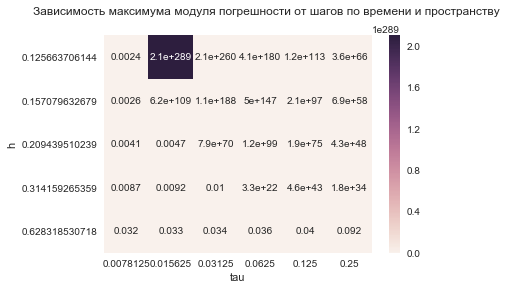

In [36]:
plot_errors(expl_results)

# Выводы
Экспериментально показано, что явный метод не обладает свойством абсолютной устойчивости: при малых шагах по времени и пространству наблюдаются наихудшие результаты за счёт накопления ошибок округления. Однако этот метод условно устойчив: в первом столбце и последней строке матрицы наблюдается снижение ошибки при уменьшении шагов по времени и пространству, поскольку параметры $h$ и $\tau$ в этих ячейках (кроме правой нижней ячейки) удовлетворяют условию $\tau/h^2 \le 0.5,$ то есть попадают в область устойчивости метода, как видно из следующего графика:

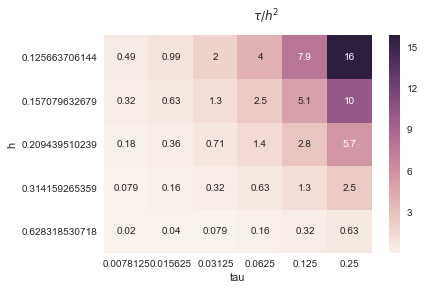

In [40]:
expl_results['tau/h^2'] = expl_results['tau'] / np.square(expl_results['h'])
sns.heatmap(expl_results.pivot("h", "tau", "tau/h^2"), annot=True)
sns.plt.suptitle(r'$\tau/h^2$')
plt.show()

Схема Кранка–Никольсон и неявный метод демонстрируют абсолютную устойчивость, причём при больших значениях $\tau$ неявный метод имеет меньшую погрешность